In [2]:
# 필요한 패키지 import
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [4]:
# 글로벌 변수 선언
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH,IMAGE_HEIGHT)
IMAGE_CHANNELS = 3 # 컬러 사진이므로 채널이 3(rgb)

In [3]:
# 파일명과 정답 설정
filenames = os.listdir("./cats")
categories = []
answer = {}
reverse_answer = {}
j=0
trigger = False
for filename in filenames:
    category = ''
    for i in filename.split('_'):
        if i[-4:] == '.jpg':
            category = category[:-1]
            break
        category += i + '_'
    if answer.get(category) == None:
        categories.append(j)
        answer[category] = j
        reverse_answer[j] = category
        j+=1
    else:
        categories.append(answer[category])
df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})
print(answer)
print(reverse_answer)

{'Egyptian_Mau': 0, 'japanese_chin': 1, 'keeshond': 2, 'pug': 3, 'Maine_Coon': 4, 'yorkshire_terrier': 5, 'scottish_terrier': 6, 'shiba_inu': 7, 'havanese': 8, 'Bengal': 9, 'Abyssinian': 10, 'Birman': 11, 'Ragdoll': 12, 'Bombay': 13, 'samoyed': 14, 'german_shorthaired': 15, 'english_cocker_spaniel': 16, 'boxer': 17, 'Siamese': 18, 'american_bulldog': 19, 'British_Shorthair': 20, 'english_setter': 21, 'pomeranian': 22, 'basset_hound': 23, 'wheaten_terrier': 24, 'Russian_Blue': 25, 'beagle': 26, 'american_pit_bull_terrier': 27, 'newfoundland': 28, 'Sphynx': 29, 'staffordshire_bull_terrier': 30, 'miniature_pinscher': 31, 'saint_bernard': 32, 'Persian': 33, 'chihuahua': 34, 'great_pyrenees': 35, 'leonberger': 36, 'Abyssinian_101.mat_': 37, 'Abyssinian_102.mat_': 38, 'Abyssinian_100.mat_': 39}
{0: 'Egyptian_Mau', 1: 'japanese_chin', 2: 'keeshond', 3: 'pug', 4: 'Maine_Coon', 5: 'yorkshire_terrier', 6: 'scottish_terrier', 7: 'shiba_inu', 8: 'havanese', 9: 'Bengal', 10: 'Abyssinian', 11: 'Birm

In [6]:
df.head()

,filename,category
0,Egyptian_Mau_96.jpg,0
1,japanese_chin_59.jpg,1
2,keeshond_162.jpg,2
3,pug_93.jpg,3
4,Maine_Coon_144.jpg,4


In [7]:
df.tail()

,filename,category
7388,american_bulldog_136.jpg,19
7389,pomeranian_53.jpg,22
7390,american_pit_bull_terrier_181.jpg,27
7391,miniature_pinscher_93.jpg,31
7392,Egyptian_Mau_100.jpg,0


In [8]:
# 신경망 모델 구성 (cnn)
# 언제나 그렇듯 그냥 잘 나올때까지 계속 바꿔보는것
# 이 밑은 일단 따라해보는 것이다
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(37,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [9]:
# 콜백 정의
# earlystopping? 일정 횟수만큼 정확도가 떨어질때 트리거를 걸어두고 일정 횟수 더 트레이닝을 돌렸더니 또 정확도가 떨어질때 트레이닝을 끝내는 함수
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
# 학습하는 동안 정확도를 감시하다가 어느 기준이 되면 학습율을 조정해주는 클래스
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5,min_lr=0.00001)

#콜백 설정
callbacks = [earlystop,learning_rate_reduction]

In [10]:
# 카테고리 이름을 개,고양이 스트링으로 치환
# 지금이면 고양이 0 강아지 1 이런식으로 분류된다
df['category'] = df['category'].replace(reverse_answer)

In [11]:
# train-validation 데이터 분리
# train데이터 중 일부를 쪼개 (여기서는 20퍼센트)
# 검증을 위한 validation셋을 마련
train_df, validation_df = train_test_split(df,test_size=0.20,random_state=42)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

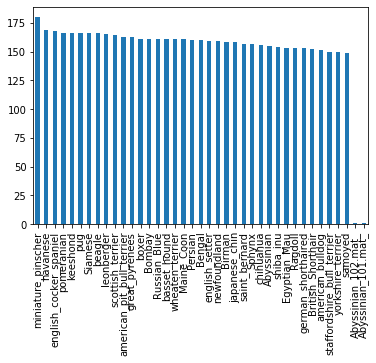

In [12]:
train_df['category'].value_counts().plot.bar()

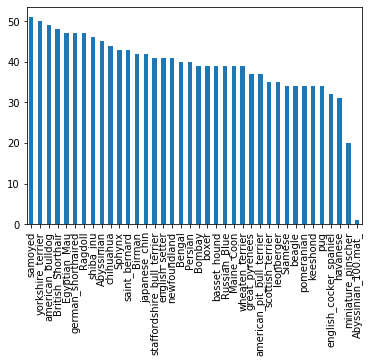

In [13]:
validation_df['category'].value_counts().plot.bar()

In [14]:
# 학습 검증데이터 확인
total_train = train_df.shape[0]
total_validate = validation_df.shape[0]
batch_size = 15 # 한번에 학습할 갯수

In [15]:
# 학습 데이터 뻥튀기
# 부풀리는 방법은 이미지 회전, 줌, 상하/좌우반전 등
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    './cats/',
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# validation도 마찬가지로 뻥튀기
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    './cats/',
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5912 validated image filenames belonging to 37 classes.
Found 1478 validated image filenames belonging to 37 classes.


/home/team2/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/home/team2/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [16]:
# 샘플 확인
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    './cats/',
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


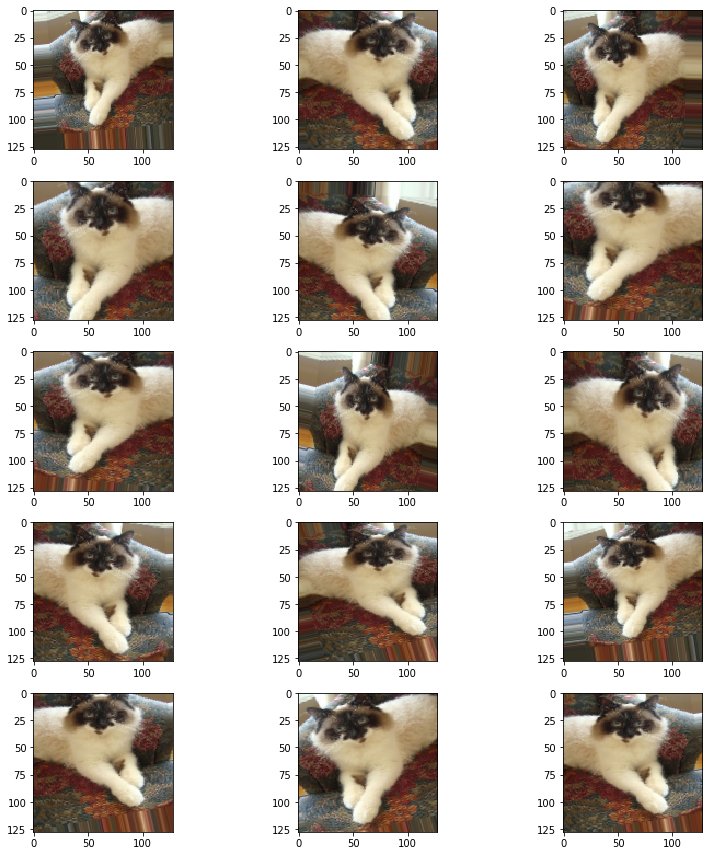

In [17]:
# 이미지 확인하기
plt.figure(figsize=(12,12))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [18]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3470279434229624123,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5646183253638146277
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6106664192741712542
 physical_device_desc: "device: XLA_GPU device"]

In [19]:
# 학습시작
# 시작 시간 200915/05:13/PM

epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
394/394 [==============================] - 64s 163ms/step - loss: 4.2906 - accuracy: 0.0648 - val_loss: 3.6302 - val_accuracy: 0.0612
Epoch 2/50
394/394 [==============================] - 63s 160ms/step - loss: 3.6767 - accuracy: 0.1021 - val_loss: 3.3010 - val_accuracy: 0.1265
Epoch 3/50
394/394 [==============================] - 63s 159ms/step - loss: 3.3266 - accuracy: 0.1333 - val_loss: 3.2648 - val_accuracy: 0.1395
Epoch 4/50
394/394 [==============================] - 63s 159ms/step - loss: 3.1235 - accuracy: 0.1599 - val_loss: 3.0969 - val_accuracy: 0.1755
Epoch 5/50
394/394 [==============================] - 62s 159ms/step - loss: 3.0026 - accuracy: 0.1850 - val_loss: 2.9647 - val_accuracy: 0.1884
Epoch 6/50
394/394 [==============================] - 63s 159ms/step - loss: 2.8869 - accuracy: 0.2084 - val_loss: 3.0022 - val_accuracy: 0.2054
Epoch 7/50
394/394 [==============================] - 

394/394 [==============================] - 62s 158ms/step - loss: 2.1022 - accuracy: 0.4061 - val_loss: 2.4895 - val_accuracy: 0.3415
Epoch 22/50
394/394 [==============================] - 62s 158ms/step - loss: 2.0780 - accuracy: 0.4128 - val_loss: 2.2482 - val_accuracy: 0.3721
Epoch 23/50
394/394 [==============================] - 62s 157ms/step - loss: 2.0480 - accuracy: 0.4177 - val_loss: 2.0641 - val_accuracy: 0.4184
Epoch 24/50
394/394 [==============================] - 62s 157ms/step - loss: 2.0393 - accuracy: 0.4192 - val_loss: 2.4807 - val_accuracy: 0.3497
Epoch 25/50
394/394 [==============================] - 62s 157ms/step - loss: 1.9937 - accuracy: 0.4336 - val_loss: 2.5545 - val_accuracy: 0.3116
Epoch 26/50
394/394 [==============================] - 62s 157ms/step - loss: 2.0030 - accuracy: 0.4255 - val_loss: 2.3547 - val_accuracy: 0.3830
Epoch 27/50
394/394 [==============================] - 62s 157ms/step - loss: 1.9454 - accuracy: 0.4494 - val_loss: 2.0978 - val_accurac

Epoch 43/50
394/394 [==============================] - 62s 157ms/step - loss: 1.6965 - accuracy: 0.5145 - val_loss: 2.1124 - val_accuracy: 0.4605


In [20]:
model_json = model.to_json()
with open('CNN_dog_and_cat_breed_model.json','w') as json_file:
    json_file.write(model_json)

model.save_weights('CNN_dog_and_cat_breed_model.h5')
print('Saved model to disk')

Saved model to disk


In [4]:
# Test를 해보장
test_filenames = os.listdir('./dogvscat/test1/')
test_df = pd.DataFrame({
    'filename':test_filenames
})
nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    './dogvscat/test1/',
    x_col='filename',
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

# 모델 예측
predict = model.predict_generator(test_generator,steps=np.ceil(nb_samples/batch_size))

# 평가 생성
# 확률이 큰 걸로 라벨을 붙여준다
test_df['category'] = np.argmax(predict,axis=-1)

# 레이블 변환
# 평가를 위해서 dog,cat으로 있던걸 다시 1,0으로 변환
print(test_df['category'])
# test_df['category'] = test_df['category'].replace({'dog':1,'cat':0})

# 정답 확인!
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12,24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('./dogvscat/test1/'+filename,target_size=IMAGE_SIZE)
    plt.subplot(6,3,index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + '{}'.format(reverse_answer[category]) + ')')
plt.tight_layout()
plt.show()

NameError: name 'IMAGE_SIZE' is not defined